Consider linear problem

$$ y = G \theta + \eta $$

In [1]:
using LinearAlgebra
using PyPlot
include("../Inversion/Diffusion.jl")
include("../Inversion/Plot.jl")

function Two_Param_Linear_Test(problem_type::String, θ0_bar, θθ0_cov)
    N_θ = length(θ0_bar)
    
    if problem_type == "under-determined"
        # under-determined case
        θ_ref = [0.6, 1.2]
        G = [1.0 2.0;]
        y = [3.0;]
        Σ_η = Array(Diagonal(fill(0.1^2, size(y))))
         
    elseif problem_type == "over-determined"
        # over-determined case
        θ_ref = [1/3, 8.5/6]
        G = [1.0 2.0; 3.0 4.0; 5.0 6.0]
        y = [3.0;7.0;10.0]
        Σ_η = Array(Diagonal(fill(0.1^2, size(y))))
        
    elseif problem_type == "Hilbert"
        G = zeros(N_θ, N_θ)
        for i = 1:N_θ
            for j = 1:N_θ
                G[i,j] = 1/(i + j - 1)
            end
        end
        θ_ref = fill(1.0, N_θ)
        y   = G*θ_ref 
        Σ_η = Array(Diagonal(fill(0.5^2, N_θ)))
        
    else
        error("Problem type : ", problem_type, " has not implemented!")
    end
    
    Σ_post = inv(G'*(Σ_η\G) + inv(θθ0_cov))
    θ_post = θ0_bar + Σ_post*(G'*(Σ_η\(y - G*θ0_bar)))
    
    return θ_post, Σ_post, G, y, Σ_η
end


mutable struct Setup_Param{MAT, IT<:Int}
    θ_names::Array{String,1}
    G::MAT
    N_θ::IT
    N_y::IT
end

function Setup_Param(G, N_θ::IT, N_y::IT) where {IT<:Int}
    return Setup_Param(["θ"], G, N_θ, N_y)
end


function forward(s_param::Setup_Param, θ::Array{FT, 1}) where {FT<:AbstractFloat}
    G = s_param.G 
    return G * θ
end

function construct_cov(x::Array{FT,2}) where {FT<:AbstractFloat}
    x_mean = dropdims(mean(x, dims=1), dims=1)
    N_ens, N_x = size(x)
    
    x_cov = zeros(FT, N_x, N_x)
    
    for i = 1: N_ens
        x_cov .+= (x[i,:] - x_mean)*(x[i,:] - x_mean)'
    end
    return x_cov/N_ens
end


construct_cov (generic function with 3 methods)

[ Info: [0.0, 0.9524360301070914, 1.859517963542402, 2.7234055191950786, 3.5461555721976277, 4.329727051247675, 5.075985602723909, 5.786708032701275, 6.463586537441625, 7.108232732432434, 7.7221814895665375, 8.306894591599017, 8.86376421258233, 9.39411623256644, 9.899213394456066, 10.380258310541425, 10.838396325860815, 11.274718245212615, 11.690262930309567, 12.086019773259045, 12.462931052258547, 12.821894175115217, 13.163763815931093, 13.489353950041451, 13.799439792051315, 14.094759641584519, 14.376016641139952, 14.643880450240363, 14.898988839859804, 15.141949210925937, 15.37334004051273, 15.59371225916682, 15.803590562646905, 16.003474661199366, 16.19384046934457, 16.375141239006666, 16.547808638684852, 16.712253781235507, 16.86886820271232, 17.018024794595, 17.160078691626122, 17.29536811737005, 17.424215189507123, 17.546926686780527, 17.663794779421863, 17.775097724794566, 17.881100529911425, 17.98205558240367, 18.078203251443906, 18.169772460053654, 18.256981230158175, 18.3400

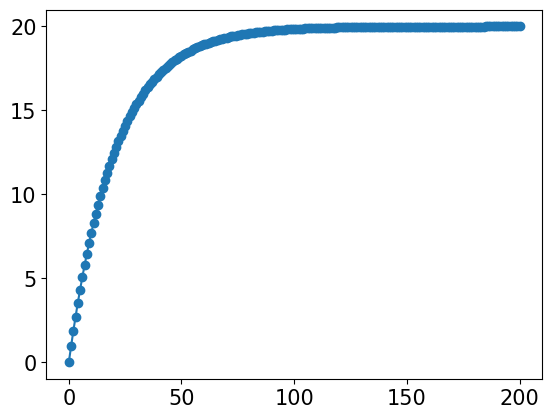

In [8]:
ts = GeoSpace(0.0, 20, 201; r = 1.05)
plot(ts, "-o")
@info ts

[ Info: Correct the initial condition, such that the empirical mean is 0, the empirical covariance is I.
[ Info: Correct the initial condition, such that the empirical mean is 0, the empirical covariance is I.


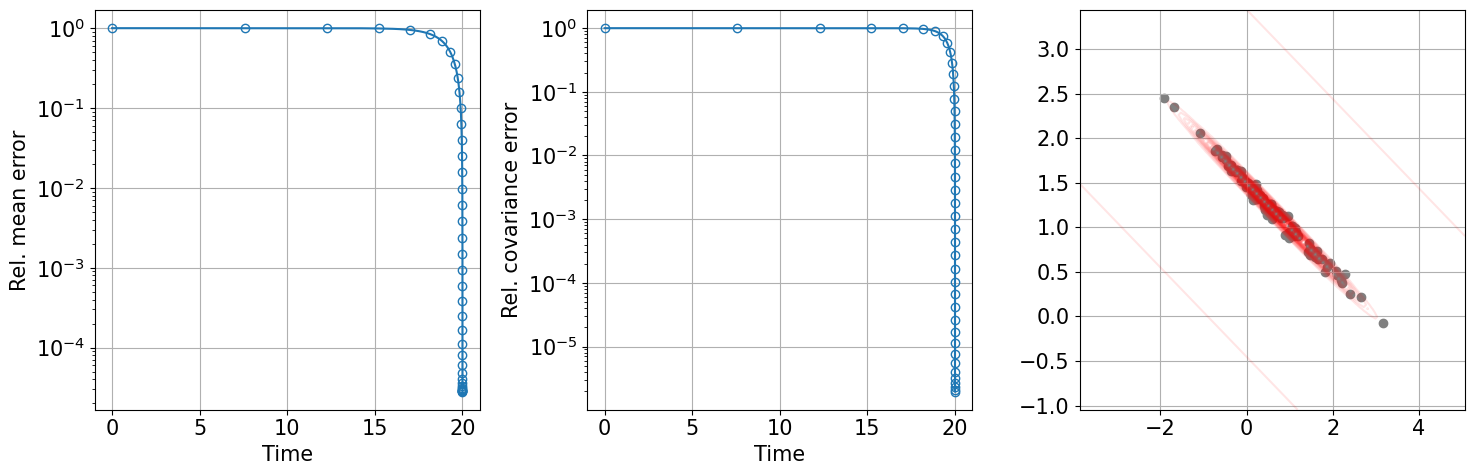

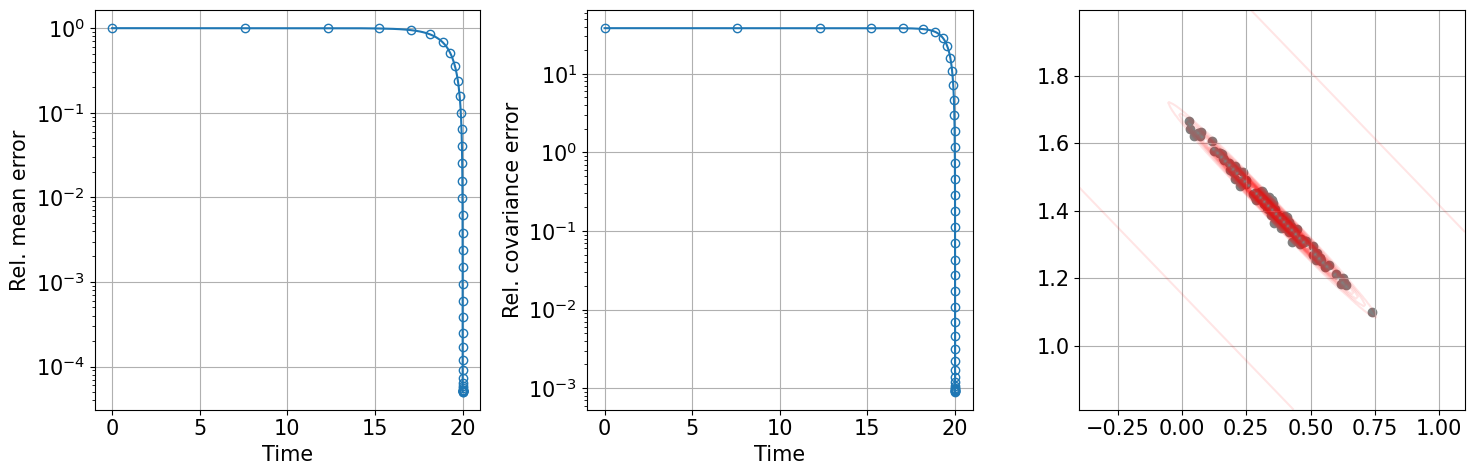

In [11]:
FT = Float64

Random.seed!(123)
N_iter = 200 #100000
T = 20.0
ts = GeoSpace(0.0, T, N_iter+1; r = 1.1)
N_θ = 2
prior_mean  = zeros(FT, N_θ)
prior_cov   = Array(Diagonal(fill(1.0^2, N_θ)))

for problem_type in ("under-determined", "over-determined")
    
    θ_post, Σ_post, G, y, Σ_η = Two_Param_Linear_Test(problem_type, prior_mean, prior_cov)
    
    N_y = length(y)
    
    s_param = Setup_Param(G, N_θ, N_y)
     
    filter_type = "cubature_transform"
    N_p = 100
    # the initial condition is always N(0,I)
    θ0 = Array(rand(Normal(0, 1), N_p, N_θ))
    
    
    diffki_obj = DiffusionKI_Run(s_param, forward, θ0, prior_mean, prior_cov, 
                                 y, Σ_η, T, N_iter; ts = ts, filter_type = "cubature_transform", randomized_update = false)
    
        
    diffki_errors    = zeros(FT, N_iter+1, 2)
    
    
    for i = 1:N_iter+1
        
        diffki_errors[i, 1] = norm(dropdims(mean(diffki_obj.θ[i], dims=1), dims=1) .- θ_post)/norm(θ_post)
        diffki_errors[i, 2] = norm(construct_cov(diffki_obj.θ[i]) .- Σ_post)/norm(Σ_post)
        
    end
    
    ites = Array(0:N_iter)
    

    markevery = 5
    
    fig, ax = PyPlot.subplots(nrows = 1, ncols=3, sharex=false, sharey=false, figsize=(15,5))
    ax[1].semilogy(ts, diffki_errors[:, 1],   "-o", color = "C0", fillstyle="none", label="Diff-KI)", markevery = markevery)
    ax[1].set_xlabel("Time")
    ax[1].set_ylabel("Rel. mean error")
    ax[1].grid("on")
    

    ax[2].semilogy(ts, diffki_errors[:, 2],   "-o", color = "C0", fillstyle="none", label="Diff-KI", markevery = markevery)
    ax[2].set_xlabel("Time")
    ax[2].set_ylabel("Rel. covariance error")
    ax[2].grid("on")
    # ax[2].legend(bbox_to_anchor=(1.0, 1.0))
        
    
    Nx = Ny = 100 
    X,Y,Z = Gaussian_2d(θ_post, Σ_post, Nx, Ny)
    ax[3].contour(X, Y, Z, 50, colors = "red", alpha=0.1)
    ax[3].scatter(diffki_obj.θ[end][:, 1], diffki_obj.θ[end][:, 2], color = "grey")
    ax[3].grid("on") 
    
    
    fig.tight_layout()
    fig.savefig("Linear-$(problem_type).pdf")
end




In [5]:
import Pkg; Pkg.add("Roots")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed Roots ─ v2.0.22
    Updating `~/.julia/environments/v1.9/Project.toml`
  [f2b01f46] + Roots v2.0.22
    Updating `~/.julia/environments/v1.9/Manifest.toml`
  [f2b01f46] + Roots v2.0.22
Precompiling project...
  ✓ Roots
  ✓ Roots → RootsForwardDiffExt
  2 dependencies successfully precompiled in 3 seconds. 203 already precompiled.
